In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines();
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
chars = sorted(set(''.join(words)));
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0;
itos = {i:s for s,i in  stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
def build_dataset(words):
    block_size= 3;
    X,Y = [], [];
    for w in words[:]:
        #print(w);
        context = [0]  * block_size;
        for ch in w + '.':
       
            ix = stoi[ch]
            X.append(context);1
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix];
        
    X = torch.tensor(X);
    Y = torch.tensor(Y);
    return X,Y

import random
random.seed(42);
random.shuffle(words);
n1 = int(0.8 * len(words));
n2 = int(0.9 * len(words));
Xtr, Ytr = build_dataset(words[:n1]);
Xdev, Ydev = build_dataset(words[:n2])
Xte, Yte = build_dataset(words[n2:])
block_size = 3;
vocab_size = len(itos)

Xtr

    

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])

In [7]:
#we want logits to be close to zero
#the reason for this is at the beginning we dont know anything 
#so we assume each character has equal likelihood to appear
#logits closer to zero make the probabilty closer to uniform distribution
#Tahs why mulipty W2 by some very lagre no and bb 0

n_embd= 10;
n_hidden =200# no of neurons
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3) / ((n_embd * block_size) ** 2)
#b1 = torch.randn(n_hidden, generator=g)* 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bmean_running = torch.zeros((1, n_hidden))
bstd_running = torch.ones((1, n_hidden))
parameters = [C, W1,W2, b2, bnbias, bngain]
for p in parameters:
    p.requires_grad =True;



In [8]:
max_steps = 20000
batch_size = 32;
lossi = [];
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb];
    embcat = emb.view(emb.shape[0], - 1);
    hpreact = embcat@W1 
    # By subtracting the mean and dividing by the standard deviation, 
    # you are guaranteeing that the distribution of hpreact is centered at 0 with a spread of 1.
    #which emsures that your valeus fall between 1 and -1 when they hit the tanh function
# Think of the normalization step (x - mean) / std as a "Rough Reset." It aggressively forces every single neuron into a narrow, centered box.
# bngain and bnbias are the "Fine-Tuning" knobs. They allow the network to say:
# "Thanks for centering this for me so I don't saturate, but actually, I've learned that this specific feature
# is more useful if it's shifted slightly to the right."
# Without these two parameters, you are telling the network: "You must use a Mean 0, Std 1 distribution 
# for every single hidden layer, no matter what." That limits the "expressive power" of your model.
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias
    with torch.no_grad():
        bmean_running = 0.999 * bmean_running + 0.001 * bnmeani
        bstd_running = 0.999 * bstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward();
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data+= -lr * (p.grad)
    lossi.append(loss.log10().item())
    
print(loss)

tensor(2.1196, grad_fn=<NllLossBackward0>)


In [9]:

#We do this  i.e calculate bmean and bstd once and use it in the forward pass
# this is static and wont change

#this is explicit caliberation
#We dont really need it since we are maintaining running mean and std
with torch.no_grad():
    emb = C[Xtr];
    embcat = emb.view(emb.shape[0],-1, )
    hpreact = embcat @ W1 
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim=True)

In [10]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], - 1)
    hpreact = embcat @W1 
    hpreact = bngain * (hpreact - bmean_running) / (bstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @W2 + b2
    loss = F.cross_entropy(logits, y);
    print(split, loss.item())
    
    
split_loss('train')
split_loss('val')
    

train 2.168099880218506
val 2.1693429946899414


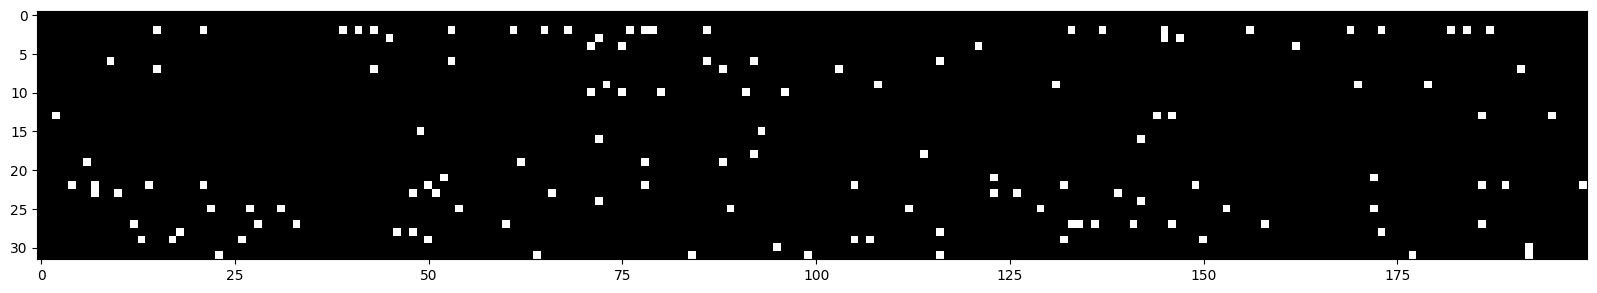

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray',interpolation='nearest')

(array([270., 212., 167., 124., 124., 148., 153., 102., 102., 110., 137.,
        157., 154., 122., 103., 106., 130.,  88.,  91.,  98.,  68., 106.,
        100., 137.,  77.,  99.,  90., 104., 112., 113.,  87., 111., 112.,
         99., 134., 111.,  86., 130., 140., 103., 121., 116., 120., 131.,
        126., 163., 124., 206., 191., 285.]),
 array([-9.99749243e-01, -9.59762390e-01, -9.19775536e-01, -8.79788682e-01,
        -8.39801829e-01, -7.99814975e-01, -7.59828122e-01, -7.19841268e-01,
        -6.79854414e-01, -6.39867561e-01, -5.99880707e-01, -5.59893854e-01,
        -5.19907000e-01, -4.79920146e-01, -4.39933293e-01, -3.99946439e-01,
        -3.59959586e-01, -3.19972732e-01, -2.79985878e-01, -2.39999025e-01,
        -2.00012171e-01, -1.60025318e-01, -1.20038464e-01, -8.00516105e-02,
        -4.00647569e-02, -7.79032707e-05,  3.99089503e-02,  7.98958039e-02,
         1.19882658e-01,  1.59869511e-01,  1.99856365e-01,  2.39843218e-01,
         2.79830072e-01,  3.19816926e-01,  3.59803

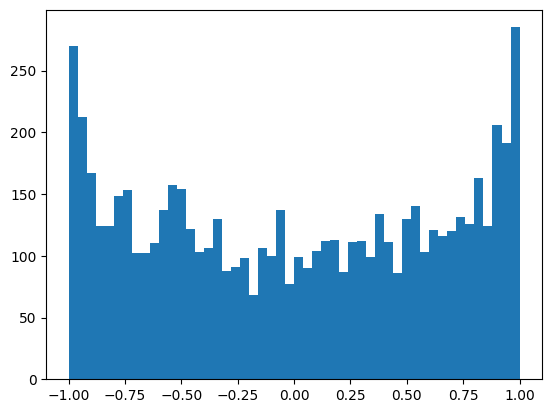

In [12]:
plt.hist(h.view(-1).tolist(), 50)

KeyboardInterrupt: 

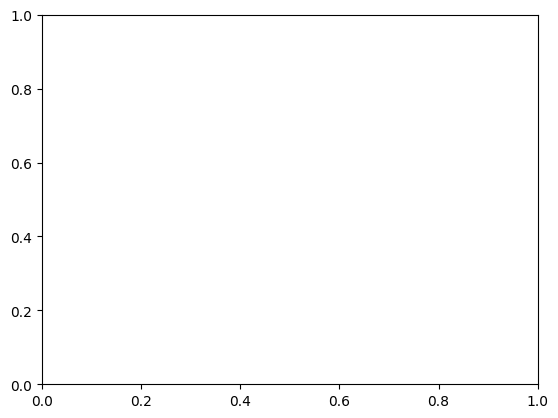

In [13]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [14]:
# #The issue that these 2 graphs highlight is the following
# the first graph shows the h after perfoming tanh and we can see that a lot of values
# are squashed to either -1 or 1
# this is very bad since this means that the gradiant would be 0
# meaning if we have incoming gradients they would just cancel at this layer

# Similarly we also want h to be close to zero as well due to the vanishing gradient problem
# hence we also multiply w1 and b1 by very small value


In [15]:
# # Now lets look at how to scale these w
# This code is a demonstration of Variance Preservation.

# You are manually implementing a simplified version of Xavier Initialization. 
# The goal is to ensure that as data flows through the network, it doesn't "explode" (get huge) or "vanish" (shrink to zero).
# Basically we are trying to preserve the original distribution of the input
x = torch.randn(1000, 10);
w = torch.randn(10, 200) / (10 ** 0.5);
y = x @ w;
print(x.mean(), x.std());
print(y.mean(), y.std());

tensor(-0.0072) tensor(1.0042)
tensor(-0.0012) tensor(0.9713)


#Refactoring our code and making it more Like pyotorch functions

In [16]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in **0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @self.weight;
        if self.bias is not None:
            self.out += self.bias
        self.out.requires_grad_()
        return self.out;
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1, training=True):
        self.eps = eps;
        self.momentum = momentum
        self.training = training
        #paramaters which are trainable
        self.gamma = torch.ones(dim);
        self.beta = torch.zeros(dim);
        
        #we also maintain running mean and variance which in pytorch terminology are known as buffers
        self.running_mean = torch.zeros(dim);
        self.running_var = torch.ones(dim)
        
        
    def __call__(self, x):
        #We calc the forward pass:
        if self.training:
            xmean = x.mean(0, keepdim=True)#batch mean
            xvar = x.var(0, keepdim = True)#batch variance
        else:
            xmean = self.running_mean;
            xvar = self.running_var;
            
        xhat = (x - xmean) / (torch.sqrt(xvar + self.eps))
        
        self.out = self.gamma * xhat + self.beta
        self.out.requires_grad_()
        #updating the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * (self.running_mean) + self.momentum * xmean
                self.running_var = (1 - self.momentum) * (self.running_var) + self.momentum *xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x);
        self.out.requires_grad_()
        return self.out
    def parameters(self):
        return []
    
n_embd = 10
n_hidden=100
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [Linear(n_embd* block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, vocab_size),BatchNorm1d(vocab_size),
          
          ]
with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # a very low weight makes the values very low and closer to zero the problem is that then we loose no linearity
            
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

            
            
        

In [17]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    #forward pass
    emb= C[Xb];
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad();
    for p in parameters:
        p.grad = None;
    loss.backward();
    lr = 0.1 if i <= 10000 else  0.01
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std()/ p.data.std()).log().item() for p in parameters])
print(loss.item())
    
    
    
    

2.258234739303589


layer 2 (      Tanh): mean +0.00, std 0.64, saturated: 4.09%
layer 5 (      Tanh): mean -0.01, std 0.65, saturated: 4.97%
layer 8 (      Tanh): mean +0.01, std 0.66, saturated: 4.81%
layer 11 (      Tanh): mean -0.00, std 0.67, saturated: 3.56%
layer 14 (      Tanh): mean -0.00, std 0.68, saturated: 3.09%


Text(0.5, 1.0, 'activation distribution')

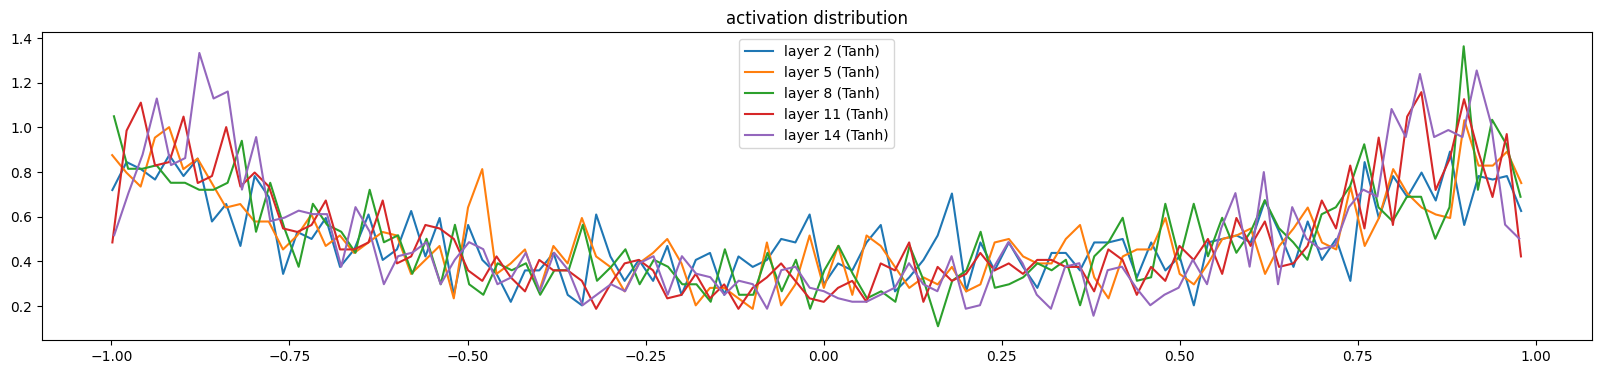

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Visualize histograms of the Tanh activations
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

# Iterate through all layers except the very last output layer
for i, layer in enumerate(layers[:-1]): 
    if isinstance(layer, Tanh):
        t = layer.out
        # Calculate saturation: what % of values have an absolute value > 0.97?
        # Tanh squashes to [-1, 1], so > 0.97 means it's in the "flat" region.
        saturated = (t.abs() > 0.97).float().mean() * 100
        
        print(f'layer {i} ({layer.__class__.__name__:>10s}): mean {t.mean():+.2f}, std {t.std():.2f}, saturated: {saturated:.2f}%')
        
        # Compute histogram
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('activation distribution')

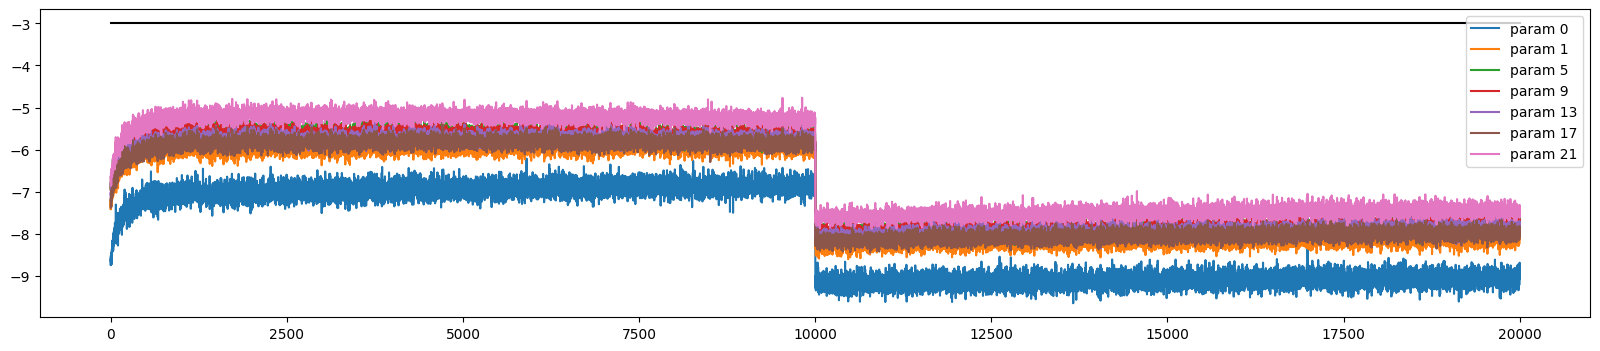

In [19]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d'%i)
        
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
    

In [20]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]
    x_input = emb.view(emb.shape[0], -1)
    for layer in layers:
       if hasattr(layer, 'training'):
            layer.training = False 
       x_input = layer(x_input)
    loss = F.cross_entropy(x_input, y);
    print(split, loss.item())
    
    

split_loss('val')
    

val 2.161151170730591


In [21]:
for _ in range(20):
    out = [];
    context = [0] * block_size;
    while True:
        emb = C[torch.tensor([context])];
        x_input = emb.view(1,-1)
        for layer in layers:
            if hasattr(layer, 'training'):
                layer.training = False;
            x_input = layer(x_input)
        
        probs = F.softmax(x_input, dim=1);
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

cohryma.
alanna.
saydine.
maritheabini.
isiana.
jhe.
catarleros.
alpeejsee.
joan.
jadesiry.
lylamael.
loa.
meson.
jodbel.
julie.
kali.
sera.
mahyana.
ilyn.
javelaeely.
